###  <center> Construção de uma GAN(Generative Adversarial Network) pra gerar imagens do dataset <i>MNIST</i> </center>
- Autor: Edwin Jahir Rueda Rojas
- email: ejrueda95g@gmail.com

In [11]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
class GANs():
    #inialização dos parâmetros
    def __init__(self, width, height, channels, noise_input):
        self.width = width
        self.height = height
        self.channels = channels
        self.dim = (self.width, self.height, self.channels)
        self.noise_input = noise_input
        self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.G = self.noise_generator()
        print("Compilando o gerador...")
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        self.D = self.discriminator()
        print("Compilando o discriminador...")
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
    #criação do gerador de imagens fake
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
        model.add(Dense(512))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
        model.add(Reshape((self.width, self.height, self.channels)))
        return model
    
    #criação do discriminador
    def discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.dim))
        model.add(Dense((self.width * self.height * self.channels), input_shape=self.dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.width * self.height * self.channels)/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        return model

    #Para unir el generador y el disctiminador
    def __stacked_generator_discriminator(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model
    
    #treinamento da GAN
    def train(self, X_train, epochs, batch):
        for cnt in range(epochs):
            random_index = np.random.randint(0, len(X_train) - np.int64(batch))
            real_images = X_train[random_index:random_index + np.int64(batch)].reshape(np.int64(batch),
                                                                                            self.width,
                                                                                            self.height,
                                                                                            self.channels)
            gen_noise = np.random.normal(0, 1, (np.int64(batch), self.noise_input))
            #gerando as imagens fake 
            syntetic_images = self.G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((real_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch), 1)),
                                               np.zeros((np.int64(batch), 1))))
            #treino do discriminador
            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator
            noise = np.random.normal(0, 1, (batch, self.noise_input))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0],
                                                                                           g_loss))
    #gerar imagens novas
    def predict(self, noise):
        return self.G.predict(noise)

In [57]:
(X_train,_),(_,_) = mnist.load_data()
X_train = (X_train - (255/2))/(255/2)
X_train = np.expand_dims(X_train, axis=3)

In [58]:
obj_gan = GANs(28,28,1,100)

Compilando o gerador...
Compilando o discriminador...


In [64]:
obj_gan.train(X_train,3000,128)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.582186], [ Generator :: loss: 0.660860]
epoch: 1, [Discriminator :: d_loss: 0.518477], [ Generator :: loss: 1.197342]
epoch: 2, [Discriminator :: d_loss: 0.486767], [ Generator :: loss: 0.855167]
epoch: 3, [Discriminator :: d_loss: 0.474886], [ Generator :: loss: 1.103059]
epoch: 4, [Discriminator :: d_loss: 0.475324], [ Generator :: loss: 0.903221]
epoch: 5, [Discriminator :: d_loss: 0.554038], [ Generator :: loss: 0.649567]
epoch: 6, [Discriminator :: d_loss: 0.539427], [ Generator :: loss: 1.374075]
epoch: 7, [Discriminator :: d_loss: 0.567174], [ Generator :: loss: 0.500607]
epoch: 8, [Discriminator :: d_loss: 0.608571], [ Generator :: loss: 1.461819]
epoch: 9, [Discriminator :: d_loss: 0.587494], [ Generator :: loss: 0.488562]
epoch: 10, [Discriminator :: d_loss: 0.614796], [ Generator :: loss: 1.351874]
epoch: 11, [Discriminator :: d_loss: 0.558171], [ Generator :: loss: 0.601264]
epoch: 12, [Discriminator :: d_loss: 0.564220], [ Generator ::

epoch: 104, [Discriminator :: d_loss: 0.581401], [ Generator :: loss: 0.653945]
epoch: 105, [Discriminator :: d_loss: 0.565034], [ Generator :: loss: 1.221569]
epoch: 106, [Discriminator :: d_loss: 0.588447], [ Generator :: loss: 0.563904]
epoch: 107, [Discriminator :: d_loss: 0.617572], [ Generator :: loss: 1.188258]
epoch: 108, [Discriminator :: d_loss: 0.577517], [ Generator :: loss: 0.654842]
epoch: 109, [Discriminator :: d_loss: 0.593251], [ Generator :: loss: 1.138795]
epoch: 110, [Discriminator :: d_loss: 0.523103], [ Generator :: loss: 0.816566]
epoch: 111, [Discriminator :: d_loss: 0.520966], [ Generator :: loss: 1.009037]
epoch: 112, [Discriminator :: d_loss: 0.547051], [ Generator :: loss: 0.728606]
epoch: 113, [Discriminator :: d_loss: 0.545901], [ Generator :: loss: 1.235153]
epoch: 114, [Discriminator :: d_loss: 0.549761], [ Generator :: loss: 0.596022]
epoch: 115, [Discriminator :: d_loss: 0.565050], [ Generator :: loss: 1.484799]
epoch: 116, [Discriminator :: d_loss: 0.

epoch: 209, [Discriminator :: d_loss: 0.523197], [ Generator :: loss: 1.223640]
epoch: 210, [Discriminator :: d_loss: 0.519489], [ Generator :: loss: 0.808912]
epoch: 211, [Discriminator :: d_loss: 0.519619], [ Generator :: loss: 1.110984]
epoch: 212, [Discriminator :: d_loss: 0.494228], [ Generator :: loss: 0.911300]
epoch: 213, [Discriminator :: d_loss: 0.474387], [ Generator :: loss: 1.036127]
epoch: 214, [Discriminator :: d_loss: 0.470435], [ Generator :: loss: 1.076520]
epoch: 215, [Discriminator :: d_loss: 0.452876], [ Generator :: loss: 1.048085]
epoch: 216, [Discriminator :: d_loss: 0.494510], [ Generator :: loss: 0.911095]
epoch: 217, [Discriminator :: d_loss: 0.490302], [ Generator :: loss: 1.142399]
epoch: 218, [Discriminator :: d_loss: 0.485134], [ Generator :: loss: 0.877255]
epoch: 219, [Discriminator :: d_loss: 0.500104], [ Generator :: loss: 1.173921]
epoch: 220, [Discriminator :: d_loss: 0.510082], [ Generator :: loss: 0.724319]
epoch: 221, [Discriminator :: d_loss: 0.

epoch: 312, [Discriminator :: d_loss: 0.542225], [ Generator :: loss: 0.761293]
epoch: 313, [Discriminator :: d_loss: 0.539571], [ Generator :: loss: 1.054369]
epoch: 314, [Discriminator :: d_loss: 0.560978], [ Generator :: loss: 0.789861]
epoch: 315, [Discriminator :: d_loss: 0.558836], [ Generator :: loss: 1.135484]
epoch: 316, [Discriminator :: d_loss: 0.560962], [ Generator :: loss: 0.846342]
epoch: 317, [Discriminator :: d_loss: 0.557142], [ Generator :: loss: 1.078414]
epoch: 318, [Discriminator :: d_loss: 0.528039], [ Generator :: loss: 0.859586]
epoch: 319, [Discriminator :: d_loss: 0.544178], [ Generator :: loss: 1.143395]
epoch: 320, [Discriminator :: d_loss: 0.524613], [ Generator :: loss: 0.804489]
epoch: 321, [Discriminator :: d_loss: 0.528100], [ Generator :: loss: 1.262840]
epoch: 322, [Discriminator :: d_loss: 0.570897], [ Generator :: loss: 0.661388]
epoch: 323, [Discriminator :: d_loss: 0.568237], [ Generator :: loss: 1.463926]
epoch: 324, [Discriminator :: d_loss: 0.

epoch: 416, [Discriminator :: d_loss: 0.657919], [ Generator :: loss: 1.595289]
epoch: 417, [Discriminator :: d_loss: 0.607328], [ Generator :: loss: 0.714649]
epoch: 418, [Discriminator :: d_loss: 0.572767], [ Generator :: loss: 1.329219]
epoch: 419, [Discriminator :: d_loss: 0.539970], [ Generator :: loss: 0.781380]
epoch: 420, [Discriminator :: d_loss: 0.550678], [ Generator :: loss: 1.316413]
epoch: 421, [Discriminator :: d_loss: 0.688221], [ Generator :: loss: 0.354925]
epoch: 422, [Discriminator :: d_loss: 0.778551], [ Generator :: loss: 1.863727]
epoch: 423, [Discriminator :: d_loss: 0.735797], [ Generator :: loss: 0.431328]
epoch: 424, [Discriminator :: d_loss: 0.740432], [ Generator :: loss: 1.499203]
epoch: 425, [Discriminator :: d_loss: 0.684288], [ Generator :: loss: 0.523861]
epoch: 426, [Discriminator :: d_loss: 0.644913], [ Generator :: loss: 1.303883]
epoch: 427, [Discriminator :: d_loss: 0.638272], [ Generator :: loss: 0.590397]
epoch: 428, [Discriminator :: d_loss: 0.

epoch: 519, [Discriminator :: d_loss: 0.568540], [ Generator :: loss: 1.322665]
epoch: 520, [Discriminator :: d_loss: 0.561728], [ Generator :: loss: 0.745413]
epoch: 521, [Discriminator :: d_loss: 0.538533], [ Generator :: loss: 1.406884]
epoch: 522, [Discriminator :: d_loss: 0.538395], [ Generator :: loss: 0.755740]
epoch: 523, [Discriminator :: d_loss: 0.558333], [ Generator :: loss: 1.166382]
epoch: 524, [Discriminator :: d_loss: 0.550295], [ Generator :: loss: 0.806552]
epoch: 525, [Discriminator :: d_loss: 0.592266], [ Generator :: loss: 1.372402]
epoch: 526, [Discriminator :: d_loss: 0.567259], [ Generator :: loss: 0.696351]
epoch: 527, [Discriminator :: d_loss: 0.574119], [ Generator :: loss: 1.421786]
epoch: 528, [Discriminator :: d_loss: 0.637113], [ Generator :: loss: 0.484484]
epoch: 529, [Discriminator :: d_loss: 0.669776], [ Generator :: loss: 1.871087]
epoch: 530, [Discriminator :: d_loss: 0.643784], [ Generator :: loss: 0.512283]
epoch: 531, [Discriminator :: d_loss: 0.

epoch: 623, [Discriminator :: d_loss: 0.598244], [ Generator :: loss: 1.045838]
epoch: 624, [Discriminator :: d_loss: 0.594269], [ Generator :: loss: 0.866810]
epoch: 625, [Discriminator :: d_loss: 0.613465], [ Generator :: loss: 1.027294]
epoch: 626, [Discriminator :: d_loss: 0.575294], [ Generator :: loss: 0.947854]
epoch: 627, [Discriminator :: d_loss: 0.598534], [ Generator :: loss: 0.825771]
epoch: 628, [Discriminator :: d_loss: 0.569619], [ Generator :: loss: 1.270375]
epoch: 629, [Discriminator :: d_loss: 0.595795], [ Generator :: loss: 0.643987]
epoch: 630, [Discriminator :: d_loss: 0.615303], [ Generator :: loss: 1.457903]
epoch: 631, [Discriminator :: d_loss: 0.665759], [ Generator :: loss: 0.496090]
epoch: 632, [Discriminator :: d_loss: 0.694094], [ Generator :: loss: 1.626611]
epoch: 633, [Discriminator :: d_loss: 0.649860], [ Generator :: loss: 0.600744]
epoch: 634, [Discriminator :: d_loss: 0.663591], [ Generator :: loss: 1.128666]
epoch: 635, [Discriminator :: d_loss: 0.

epoch: 727, [Discriminator :: d_loss: 0.617342], [ Generator :: loss: 1.336775]
epoch: 728, [Discriminator :: d_loss: 0.564185], [ Generator :: loss: 0.856236]
epoch: 729, [Discriminator :: d_loss: 0.520383], [ Generator :: loss: 1.203142]
epoch: 730, [Discriminator :: d_loss: 0.520288], [ Generator :: loss: 0.747951]
epoch: 731, [Discriminator :: d_loss: 0.545925], [ Generator :: loss: 1.275744]
epoch: 732, [Discriminator :: d_loss: 0.522377], [ Generator :: loss: 0.788680]
epoch: 733, [Discriminator :: d_loss: 0.537031], [ Generator :: loss: 1.323135]
epoch: 734, [Discriminator :: d_loss: 0.558794], [ Generator :: loss: 0.601507]
epoch: 735, [Discriminator :: d_loss: 0.588060], [ Generator :: loss: 1.558157]
epoch: 736, [Discriminator :: d_loss: 0.575484], [ Generator :: loss: 0.683840]
epoch: 737, [Discriminator :: d_loss: 0.568744], [ Generator :: loss: 1.198822]
epoch: 738, [Discriminator :: d_loss: 0.527121], [ Generator :: loss: 0.966641]
epoch: 739, [Discriminator :: d_loss: 0.

epoch: 830, [Discriminator :: d_loss: 0.509852], [ Generator :: loss: 0.969146]
epoch: 831, [Discriminator :: d_loss: 0.567708], [ Generator :: loss: 0.952302]
epoch: 832, [Discriminator :: d_loss: 0.556995], [ Generator :: loss: 1.075680]
epoch: 833, [Discriminator :: d_loss: 0.545561], [ Generator :: loss: 0.857254]
epoch: 834, [Discriminator :: d_loss: 0.531193], [ Generator :: loss: 1.269359]
epoch: 835, [Discriminator :: d_loss: 0.641992], [ Generator :: loss: 0.643500]
epoch: 836, [Discriminator :: d_loss: 0.597328], [ Generator :: loss: 1.866404]
epoch: 837, [Discriminator :: d_loss: 0.670578], [ Generator :: loss: 0.430273]
epoch: 838, [Discriminator :: d_loss: 0.683430], [ Generator :: loss: 1.791460]
epoch: 839, [Discriminator :: d_loss: 0.665049], [ Generator :: loss: 0.523426]
epoch: 840, [Discriminator :: d_loss: 0.634275], [ Generator :: loss: 1.538334]
epoch: 841, [Discriminator :: d_loss: 0.579800], [ Generator :: loss: 0.757331]
epoch: 842, [Discriminator :: d_loss: 0.

epoch: 935, [Discriminator :: d_loss: 0.515785], [ Generator :: loss: 0.804659]
epoch: 936, [Discriminator :: d_loss: 0.535397], [ Generator :: loss: 1.303954]
epoch: 937, [Discriminator :: d_loss: 0.522071], [ Generator :: loss: 0.860237]
epoch: 938, [Discriminator :: d_loss: 0.499932], [ Generator :: loss: 1.323573]
epoch: 939, [Discriminator :: d_loss: 0.569726], [ Generator :: loss: 0.674401]
epoch: 940, [Discriminator :: d_loss: 0.574932], [ Generator :: loss: 1.441769]
epoch: 941, [Discriminator :: d_loss: 0.535831], [ Generator :: loss: 0.851236]
epoch: 942, [Discriminator :: d_loss: 0.537352], [ Generator :: loss: 1.217600]
epoch: 943, [Discriminator :: d_loss: 0.614795], [ Generator :: loss: 0.830943]
epoch: 944, [Discriminator :: d_loss: 0.647165], [ Generator :: loss: 1.068734]
epoch: 945, [Discriminator :: d_loss: 0.597521], [ Generator :: loss: 0.815615]
epoch: 946, [Discriminator :: d_loss: 0.619312], [ Generator :: loss: 1.151418]
epoch: 947, [Discriminator :: d_loss: 0.

epoch: 1038, [Discriminator :: d_loss: 0.531482], [ Generator :: loss: 1.052680]
epoch: 1039, [Discriminator :: d_loss: 0.522527], [ Generator :: loss: 1.001465]
epoch: 1040, [Discriminator :: d_loss: 0.542313], [ Generator :: loss: 0.927885]
epoch: 1041, [Discriminator :: d_loss: 0.557495], [ Generator :: loss: 1.070831]
epoch: 1042, [Discriminator :: d_loss: 0.509259], [ Generator :: loss: 0.989725]
epoch: 1043, [Discriminator :: d_loss: 0.535924], [ Generator :: loss: 0.975453]
epoch: 1044, [Discriminator :: d_loss: 0.515942], [ Generator :: loss: 1.080143]
epoch: 1045, [Discriminator :: d_loss: 0.589205], [ Generator :: loss: 0.729301]
epoch: 1046, [Discriminator :: d_loss: 0.591231], [ Generator :: loss: 1.507293]
epoch: 1047, [Discriminator :: d_loss: 0.523995], [ Generator :: loss: 0.770979]
epoch: 1048, [Discriminator :: d_loss: 0.574451], [ Generator :: loss: 1.107115]
epoch: 1049, [Discriminator :: d_loss: 0.583049], [ Generator :: loss: 0.839693]
epoch: 1050, [Discriminator 

epoch: 1142, [Discriminator :: d_loss: 0.568390], [ Generator :: loss: 0.926849]
epoch: 1143, [Discriminator :: d_loss: 0.546978], [ Generator :: loss: 1.016737]
epoch: 1144, [Discriminator :: d_loss: 0.552026], [ Generator :: loss: 1.010260]
epoch: 1145, [Discriminator :: d_loss: 0.569985], [ Generator :: loss: 0.875057]
epoch: 1146, [Discriminator :: d_loss: 0.580996], [ Generator :: loss: 0.966136]
epoch: 1147, [Discriminator :: d_loss: 0.571833], [ Generator :: loss: 0.984870]
epoch: 1148, [Discriminator :: d_loss: 0.594054], [ Generator :: loss: 0.726052]
epoch: 1149, [Discriminator :: d_loss: 0.577040], [ Generator :: loss: 1.373172]
epoch: 1150, [Discriminator :: d_loss: 0.593674], [ Generator :: loss: 0.615782]
epoch: 1151, [Discriminator :: d_loss: 0.619277], [ Generator :: loss: 1.393776]
epoch: 1152, [Discriminator :: d_loss: 0.611422], [ Generator :: loss: 0.638485]
epoch: 1153, [Discriminator :: d_loss: 0.639330], [ Generator :: loss: 1.245886]
epoch: 1154, [Discriminator 

epoch: 1244, [Discriminator :: d_loss: 0.452384], [ Generator :: loss: 1.383333]
epoch: 1245, [Discriminator :: d_loss: 0.599241], [ Generator :: loss: 0.490352]
epoch: 1246, [Discriminator :: d_loss: 0.661106], [ Generator :: loss: 1.615804]
epoch: 1247, [Discriminator :: d_loss: 0.730592], [ Generator :: loss: 0.363483]
epoch: 1248, [Discriminator :: d_loss: 0.738473], [ Generator :: loss: 1.723116]
epoch: 1249, [Discriminator :: d_loss: 0.674846], [ Generator :: loss: 0.738771]
epoch: 1250, [Discriminator :: d_loss: 0.527455], [ Generator :: loss: 1.186004]
epoch: 1251, [Discriminator :: d_loss: 0.513488], [ Generator :: loss: 1.053983]
epoch: 1252, [Discriminator :: d_loss: 0.548723], [ Generator :: loss: 0.750524]
epoch: 1253, [Discriminator :: d_loss: 0.564859], [ Generator :: loss: 1.119862]
epoch: 1254, [Discriminator :: d_loss: 0.504713], [ Generator :: loss: 0.902665]
epoch: 1255, [Discriminator :: d_loss: 0.521213], [ Generator :: loss: 1.239061]
epoch: 1256, [Discriminator 

epoch: 1346, [Discriminator :: d_loss: 0.499541], [ Generator :: loss: 1.088899]
epoch: 1347, [Discriminator :: d_loss: 0.516687], [ Generator :: loss: 0.862438]
epoch: 1348, [Discriminator :: d_loss: 0.565566], [ Generator :: loss: 1.212662]
epoch: 1349, [Discriminator :: d_loss: 0.524125], [ Generator :: loss: 1.000950]
epoch: 1350, [Discriminator :: d_loss: 0.526561], [ Generator :: loss: 1.157949]
epoch: 1351, [Discriminator :: d_loss: 0.577392], [ Generator :: loss: 0.640968]
epoch: 1352, [Discriminator :: d_loss: 0.588675], [ Generator :: loss: 1.614350]
epoch: 1353, [Discriminator :: d_loss: 0.678830], [ Generator :: loss: 0.412678]
epoch: 1354, [Discriminator :: d_loss: 0.688112], [ Generator :: loss: 1.677232]
epoch: 1355, [Discriminator :: d_loss: 0.662583], [ Generator :: loss: 0.590368]
epoch: 1356, [Discriminator :: d_loss: 0.600926], [ Generator :: loss: 1.524269]
epoch: 1357, [Discriminator :: d_loss: 0.663020], [ Generator :: loss: 0.557613]
epoch: 1358, [Discriminator 

epoch: 1448, [Discriminator :: d_loss: 0.569606], [ Generator :: loss: 1.066046]
epoch: 1449, [Discriminator :: d_loss: 0.574713], [ Generator :: loss: 0.801883]
epoch: 1450, [Discriminator :: d_loss: 0.579883], [ Generator :: loss: 1.185661]
epoch: 1451, [Discriminator :: d_loss: 0.515141], [ Generator :: loss: 0.904149]
epoch: 1452, [Discriminator :: d_loss: 0.497617], [ Generator :: loss: 1.416061]
epoch: 1453, [Discriminator :: d_loss: 0.552867], [ Generator :: loss: 0.567705]
epoch: 1454, [Discriminator :: d_loss: 0.624482], [ Generator :: loss: 1.518066]
epoch: 1455, [Discriminator :: d_loss: 0.569468], [ Generator :: loss: 0.745879]
epoch: 1456, [Discriminator :: d_loss: 0.545154], [ Generator :: loss: 1.290896]
epoch: 1457, [Discriminator :: d_loss: 0.525182], [ Generator :: loss: 0.856823]
epoch: 1458, [Discriminator :: d_loss: 0.538504], [ Generator :: loss: 0.956848]
epoch: 1459, [Discriminator :: d_loss: 0.503853], [ Generator :: loss: 1.277543]
epoch: 1460, [Discriminator 

epoch: 1551, [Discriminator :: d_loss: 0.516472], [ Generator :: loss: 0.999959]
epoch: 1552, [Discriminator :: d_loss: 0.480962], [ Generator :: loss: 1.248111]
epoch: 1553, [Discriminator :: d_loss: 0.526360], [ Generator :: loss: 0.734473]
epoch: 1554, [Discriminator :: d_loss: 0.515280], [ Generator :: loss: 1.314169]
epoch: 1555, [Discriminator :: d_loss: 0.640077], [ Generator :: loss: 0.593748]
epoch: 1556, [Discriminator :: d_loss: 0.583901], [ Generator :: loss: 1.468607]
epoch: 1557, [Discriminator :: d_loss: 0.537306], [ Generator :: loss: 0.871816]
epoch: 1558, [Discriminator :: d_loss: 0.526467], [ Generator :: loss: 1.065464]
epoch: 1559, [Discriminator :: d_loss: 0.511825], [ Generator :: loss: 0.964878]
epoch: 1560, [Discriminator :: d_loss: 0.520456], [ Generator :: loss: 1.069720]
epoch: 1561, [Discriminator :: d_loss: 0.452731], [ Generator :: loss: 1.159601]
epoch: 1562, [Discriminator :: d_loss: 0.450150], [ Generator :: loss: 1.176896]
epoch: 1563, [Discriminator 

epoch: 1653, [Discriminator :: d_loss: 0.570338], [ Generator :: loss: 1.376640]
epoch: 1654, [Discriminator :: d_loss: 0.549493], [ Generator :: loss: 0.863551]
epoch: 1655, [Discriminator :: d_loss: 0.574294], [ Generator :: loss: 0.982234]
epoch: 1656, [Discriminator :: d_loss: 0.548650], [ Generator :: loss: 1.184805]
epoch: 1657, [Discriminator :: d_loss: 0.552631], [ Generator :: loss: 0.989233]
epoch: 1658, [Discriminator :: d_loss: 0.559408], [ Generator :: loss: 0.937142]
epoch: 1659, [Discriminator :: d_loss: 0.512046], [ Generator :: loss: 1.203646]
epoch: 1660, [Discriminator :: d_loss: 0.514170], [ Generator :: loss: 0.819842]
epoch: 1661, [Discriminator :: d_loss: 0.550773], [ Generator :: loss: 1.135921]
epoch: 1662, [Discriminator :: d_loss: 0.541885], [ Generator :: loss: 0.926669]
epoch: 1663, [Discriminator :: d_loss: 0.547440], [ Generator :: loss: 1.036553]
epoch: 1664, [Discriminator :: d_loss: 0.534115], [ Generator :: loss: 0.996491]
epoch: 1665, [Discriminator 

epoch: 1757, [Discriminator :: d_loss: 0.563832], [ Generator :: loss: 0.782961]
epoch: 1758, [Discriminator :: d_loss: 0.556593], [ Generator :: loss: 1.332407]
epoch: 1759, [Discriminator :: d_loss: 0.573236], [ Generator :: loss: 0.616328]
epoch: 1760, [Discriminator :: d_loss: 0.576396], [ Generator :: loss: 1.407905]
epoch: 1761, [Discriminator :: d_loss: 0.605110], [ Generator :: loss: 0.584534]
epoch: 1762, [Discriminator :: d_loss: 0.596082], [ Generator :: loss: 1.499690]
epoch: 1763, [Discriminator :: d_loss: 0.612331], [ Generator :: loss: 0.569360]
epoch: 1764, [Discriminator :: d_loss: 0.607886], [ Generator :: loss: 1.250600]
epoch: 1765, [Discriminator :: d_loss: 0.570638], [ Generator :: loss: 0.807858]
epoch: 1766, [Discriminator :: d_loss: 0.548818], [ Generator :: loss: 1.174012]
epoch: 1767, [Discriminator :: d_loss: 0.601525], [ Generator :: loss: 0.736066]
epoch: 1768, [Discriminator :: d_loss: 0.555358], [ Generator :: loss: 1.209296]
epoch: 1769, [Discriminator 

epoch: 1859, [Discriminator :: d_loss: 0.558810], [ Generator :: loss: 0.935128]
epoch: 1860, [Discriminator :: d_loss: 0.576122], [ Generator :: loss: 0.925943]
epoch: 1861, [Discriminator :: d_loss: 0.585482], [ Generator :: loss: 0.979860]
epoch: 1862, [Discriminator :: d_loss: 0.552647], [ Generator :: loss: 0.856839]
epoch: 1863, [Discriminator :: d_loss: 0.540333], [ Generator :: loss: 1.066597]
epoch: 1864, [Discriminator :: d_loss: 0.613181], [ Generator :: loss: 0.688129]
epoch: 1865, [Discriminator :: d_loss: 0.619148], [ Generator :: loss: 1.301128]
epoch: 1866, [Discriminator :: d_loss: 0.618904], [ Generator :: loss: 0.566770]
epoch: 1867, [Discriminator :: d_loss: 0.609865], [ Generator :: loss: 1.448465]
epoch: 1868, [Discriminator :: d_loss: 0.670984], [ Generator :: loss: 0.547478]
epoch: 1869, [Discriminator :: d_loss: 0.662390], [ Generator :: loss: 1.083262]
epoch: 1870, [Discriminator :: d_loss: 0.606473], [ Generator :: loss: 0.902235]
epoch: 1871, [Discriminator 

epoch: 1961, [Discriminator :: d_loss: 0.720773], [ Generator :: loss: 0.549646]
epoch: 1962, [Discriminator :: d_loss: 0.608713], [ Generator :: loss: 1.137930]
epoch: 1963, [Discriminator :: d_loss: 0.559547], [ Generator :: loss: 0.897247]
epoch: 1964, [Discriminator :: d_loss: 0.502514], [ Generator :: loss: 1.243788]
epoch: 1965, [Discriminator :: d_loss: 0.532622], [ Generator :: loss: 0.803307]
epoch: 1966, [Discriminator :: d_loss: 0.528220], [ Generator :: loss: 1.099738]
epoch: 1967, [Discriminator :: d_loss: 0.570139], [ Generator :: loss: 0.872643]
epoch: 1968, [Discriminator :: d_loss: 0.505674], [ Generator :: loss: 1.239308]
epoch: 1969, [Discriminator :: d_loss: 0.607718], [ Generator :: loss: 0.585834]
epoch: 1970, [Discriminator :: d_loss: 0.625737], [ Generator :: loss: 1.431908]
epoch: 1971, [Discriminator :: d_loss: 0.595464], [ Generator :: loss: 0.626683]
epoch: 1972, [Discriminator :: d_loss: 0.596503], [ Generator :: loss: 1.268286]
epoch: 1973, [Discriminator 

epoch: 2064, [Discriminator :: d_loss: 0.558918], [ Generator :: loss: 0.735143]
epoch: 2065, [Discriminator :: d_loss: 0.548792], [ Generator :: loss: 1.294454]
epoch: 2066, [Discriminator :: d_loss: 0.626600], [ Generator :: loss: 0.603711]
epoch: 2067, [Discriminator :: d_loss: 0.572662], [ Generator :: loss: 1.483212]
epoch: 2068, [Discriminator :: d_loss: 0.604088], [ Generator :: loss: 0.609018]
epoch: 2069, [Discriminator :: d_loss: 0.618745], [ Generator :: loss: 1.423921]
epoch: 2070, [Discriminator :: d_loss: 0.580505], [ Generator :: loss: 0.758103]
epoch: 2071, [Discriminator :: d_loss: 0.599372], [ Generator :: loss: 0.938121]
epoch: 2072, [Discriminator :: d_loss: 0.582164], [ Generator :: loss: 1.078776]
epoch: 2073, [Discriminator :: d_loss: 0.545402], [ Generator :: loss: 0.942900]
epoch: 2074, [Discriminator :: d_loss: 0.527314], [ Generator :: loss: 0.874338]
epoch: 2075, [Discriminator :: d_loss: 0.556142], [ Generator :: loss: 1.216685]
epoch: 2076, [Discriminator 

epoch: 2168, [Discriminator :: d_loss: 0.532809], [ Generator :: loss: 1.046067]
epoch: 2169, [Discriminator :: d_loss: 0.514876], [ Generator :: loss: 1.147107]
epoch: 2170, [Discriminator :: d_loss: 0.519604], [ Generator :: loss: 0.871184]
epoch: 2171, [Discriminator :: d_loss: 0.573850], [ Generator :: loss: 0.869449]
epoch: 2172, [Discriminator :: d_loss: 0.523612], [ Generator :: loss: 1.417824]
epoch: 2173, [Discriminator :: d_loss: 0.533373], [ Generator :: loss: 0.729430]
epoch: 2174, [Discriminator :: d_loss: 0.564627], [ Generator :: loss: 1.367748]
epoch: 2175, [Discriminator :: d_loss: 0.533288], [ Generator :: loss: 0.716050]
epoch: 2176, [Discriminator :: d_loss: 0.558710], [ Generator :: loss: 1.307862]
epoch: 2177, [Discriminator :: d_loss: 0.581843], [ Generator :: loss: 0.671333]
epoch: 2178, [Discriminator :: d_loss: 0.580396], [ Generator :: loss: 1.316844]
epoch: 2179, [Discriminator :: d_loss: 0.615525], [ Generator :: loss: 0.558794]
epoch: 2180, [Discriminator 

epoch: 2272, [Discriminator :: d_loss: 0.548092], [ Generator :: loss: 0.858126]
epoch: 2273, [Discriminator :: d_loss: 0.550472], [ Generator :: loss: 1.093557]
epoch: 2274, [Discriminator :: d_loss: 0.535536], [ Generator :: loss: 0.881175]
epoch: 2275, [Discriminator :: d_loss: 0.609378], [ Generator :: loss: 0.779781]
epoch: 2276, [Discriminator :: d_loss: 0.516423], [ Generator :: loss: 1.633399]
epoch: 2277, [Discriminator :: d_loss: 0.578310], [ Generator :: loss: 0.510950]
epoch: 2278, [Discriminator :: d_loss: 0.625958], [ Generator :: loss: 1.528203]
epoch: 2279, [Discriminator :: d_loss: 0.615271], [ Generator :: loss: 0.644086]
epoch: 2280, [Discriminator :: d_loss: 0.597426], [ Generator :: loss: 1.115110]
epoch: 2281, [Discriminator :: d_loss: 0.597812], [ Generator :: loss: 0.784731]
epoch: 2282, [Discriminator :: d_loss: 0.589402], [ Generator :: loss: 1.104430]
epoch: 2283, [Discriminator :: d_loss: 0.540810], [ Generator :: loss: 0.930805]
epoch: 2284, [Discriminator 

epoch: 2375, [Discriminator :: d_loss: 0.603756], [ Generator :: loss: 0.581713]
epoch: 2376, [Discriminator :: d_loss: 0.607807], [ Generator :: loss: 1.405518]
epoch: 2377, [Discriminator :: d_loss: 0.639480], [ Generator :: loss: 0.618612]
epoch: 2378, [Discriminator :: d_loss: 0.606722], [ Generator :: loss: 1.173478]
epoch: 2379, [Discriminator :: d_loss: 0.554251], [ Generator :: loss: 0.877049]
epoch: 2380, [Discriminator :: d_loss: 0.531432], [ Generator :: loss: 1.333352]
epoch: 2381, [Discriminator :: d_loss: 0.562701], [ Generator :: loss: 0.671118]
epoch: 2382, [Discriminator :: d_loss: 0.554448], [ Generator :: loss: 1.211910]
epoch: 2383, [Discriminator :: d_loss: 0.513549], [ Generator :: loss: 1.020667]
epoch: 2384, [Discriminator :: d_loss: 0.577562], [ Generator :: loss: 0.766565]
epoch: 2385, [Discriminator :: d_loss: 0.553167], [ Generator :: loss: 1.319455]
epoch: 2386, [Discriminator :: d_loss: 0.560434], [ Generator :: loss: 0.746373]
epoch: 2387, [Discriminator 

epoch: 2478, [Discriminator :: d_loss: 0.556441], [ Generator :: loss: 1.107953]
epoch: 2479, [Discriminator :: d_loss: 0.562720], [ Generator :: loss: 0.759014]
epoch: 2480, [Discriminator :: d_loss: 0.564407], [ Generator :: loss: 1.163785]
epoch: 2481, [Discriminator :: d_loss: 0.556016], [ Generator :: loss: 0.964729]
epoch: 2482, [Discriminator :: d_loss: 0.532885], [ Generator :: loss: 1.085287]
epoch: 2483, [Discriminator :: d_loss: 0.597329], [ Generator :: loss: 0.883653]
epoch: 2484, [Discriminator :: d_loss: 0.600773], [ Generator :: loss: 1.133175]
epoch: 2485, [Discriminator :: d_loss: 0.583140], [ Generator :: loss: 0.779385]
epoch: 2486, [Discriminator :: d_loss: 0.592662], [ Generator :: loss: 1.078454]
epoch: 2487, [Discriminator :: d_loss: 0.538664], [ Generator :: loss: 1.005598]
epoch: 2488, [Discriminator :: d_loss: 0.542374], [ Generator :: loss: 0.889313]
epoch: 2489, [Discriminator :: d_loss: 0.593211], [ Generator :: loss: 0.745864]
epoch: 2490, [Discriminator 

epoch: 2582, [Discriminator :: d_loss: 0.603314], [ Generator :: loss: 0.737241]
epoch: 2583, [Discriminator :: d_loss: 0.629734], [ Generator :: loss: 1.240225]
epoch: 2584, [Discriminator :: d_loss: 0.554783], [ Generator :: loss: 0.981072]
epoch: 2585, [Discriminator :: d_loss: 0.499738], [ Generator :: loss: 1.169111]
epoch: 2586, [Discriminator :: d_loss: 0.602107], [ Generator :: loss: 0.633318]
epoch: 2587, [Discriminator :: d_loss: 0.682583], [ Generator :: loss: 1.025908]
epoch: 2588, [Discriminator :: d_loss: 0.520906], [ Generator :: loss: 1.158565]
epoch: 2589, [Discriminator :: d_loss: 0.656848], [ Generator :: loss: 0.534130]
epoch: 2590, [Discriminator :: d_loss: 0.691761], [ Generator :: loss: 1.280416]
epoch: 2591, [Discriminator :: d_loss: 0.603898], [ Generator :: loss: 0.771207]
epoch: 2592, [Discriminator :: d_loss: 0.597874], [ Generator :: loss: 0.808536]
epoch: 2593, [Discriminator :: d_loss: 0.618833], [ Generator :: loss: 1.032885]
epoch: 2594, [Discriminator 

epoch: 2684, [Discriminator :: d_loss: 0.549878], [ Generator :: loss: 0.972136]
epoch: 2685, [Discriminator :: d_loss: 0.569138], [ Generator :: loss: 0.924417]
epoch: 2686, [Discriminator :: d_loss: 0.550409], [ Generator :: loss: 1.002632]
epoch: 2687, [Discriminator :: d_loss: 0.505814], [ Generator :: loss: 1.087614]
epoch: 2688, [Discriminator :: d_loss: 0.566871], [ Generator :: loss: 0.771842]
epoch: 2689, [Discriminator :: d_loss: 0.568533], [ Generator :: loss: 1.245987]
epoch: 2690, [Discriminator :: d_loss: 0.604511], [ Generator :: loss: 0.650884]
epoch: 2691, [Discriminator :: d_loss: 0.598949], [ Generator :: loss: 1.395621]
epoch: 2692, [Discriminator :: d_loss: 0.643988], [ Generator :: loss: 0.608545]
epoch: 2693, [Discriminator :: d_loss: 0.605656], [ Generator :: loss: 1.153465]
epoch: 2694, [Discriminator :: d_loss: 0.536925], [ Generator :: loss: 0.986792]
epoch: 2695, [Discriminator :: d_loss: 0.557344], [ Generator :: loss: 0.925482]
epoch: 2696, [Discriminator 

epoch: 2787, [Discriminator :: d_loss: 0.643620], [ Generator :: loss: 1.487637]
epoch: 2788, [Discriminator :: d_loss: 0.633711], [ Generator :: loss: 0.550967]
epoch: 2789, [Discriminator :: d_loss: 0.638382], [ Generator :: loss: 1.410623]
epoch: 2790, [Discriminator :: d_loss: 0.587622], [ Generator :: loss: 0.715882]
epoch: 2791, [Discriminator :: d_loss: 0.572771], [ Generator :: loss: 1.179573]
epoch: 2792, [Discriminator :: d_loss: 0.504893], [ Generator :: loss: 1.113530]
epoch: 2793, [Discriminator :: d_loss: 0.562742], [ Generator :: loss: 0.679407]
epoch: 2794, [Discriminator :: d_loss: 0.585400], [ Generator :: loss: 1.309181]
epoch: 2795, [Discriminator :: d_loss: 0.564548], [ Generator :: loss: 0.794034]
epoch: 2796, [Discriminator :: d_loss: 0.564323], [ Generator :: loss: 1.076169]
epoch: 2797, [Discriminator :: d_loss: 0.547415], [ Generator :: loss: 0.841287]
epoch: 2798, [Discriminator :: d_loss: 0.559575], [ Generator :: loss: 1.031271]
epoch: 2799, [Discriminator 

epoch: 2889, [Discriminator :: d_loss: 0.621284], [ Generator :: loss: 0.680477]
epoch: 2890, [Discriminator :: d_loss: 0.586710], [ Generator :: loss: 1.523877]
epoch: 2891, [Discriminator :: d_loss: 0.625024], [ Generator :: loss: 0.492559]
epoch: 2892, [Discriminator :: d_loss: 0.645071], [ Generator :: loss: 1.485847]
epoch: 2893, [Discriminator :: d_loss: 0.579832], [ Generator :: loss: 0.759140]
epoch: 2894, [Discriminator :: d_loss: 0.571115], [ Generator :: loss: 1.091555]
epoch: 2895, [Discriminator :: d_loss: 0.570722], [ Generator :: loss: 0.845263]
epoch: 2896, [Discriminator :: d_loss: 0.557489], [ Generator :: loss: 1.107088]
epoch: 2897, [Discriminator :: d_loss: 0.556445], [ Generator :: loss: 0.823750]
epoch: 2898, [Discriminator :: d_loss: 0.566319], [ Generator :: loss: 0.880463]
epoch: 2899, [Discriminator :: d_loss: 0.565363], [ Generator :: loss: 1.143409]
epoch: 2900, [Discriminator :: d_loss: 0.590039], [ Generator :: loss: 0.723127]
epoch: 2901, [Discriminator 

epoch: 2993, [Discriminator :: d_loss: 0.537582], [ Generator :: loss: 1.042499]
epoch: 2994, [Discriminator :: d_loss: 0.513972], [ Generator :: loss: 0.981729]
epoch: 2995, [Discriminator :: d_loss: 0.555335], [ Generator :: loss: 0.948461]
epoch: 2996, [Discriminator :: d_loss: 0.561733], [ Generator :: loss: 0.922614]
epoch: 2997, [Discriminator :: d_loss: 0.594489], [ Generator :: loss: 0.986668]
epoch: 2998, [Discriminator :: d_loss: 0.548449], [ Generator :: loss: 0.887340]
epoch: 2999, [Discriminator :: d_loss: 0.572867], [ Generator :: loss: 0.906760]


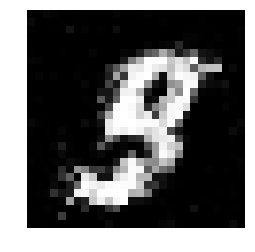

In [81]:
x = np.random.normal(0,1,(1,100))
img_pre = obj_gan.predict(x)
plt.imshow(img_pre[0].reshape(28,28), cmap="gray")
plt.axis("off");